# INDRA Database Summary

This notebook provides various summary statistics and charts over the INDRA Database (i.e., the causal relationships in INDRA CoGEx).

In [1]:
import datetime
from functools import lru_cache
from textwrap import dedent

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pystow
import seaborn as sns
from indra.assemblers.english import EnglishAssembler
from indra.literature import pubmed_client
from indra.preassembler import Preassembler
from indra.sources import SOURCE_INFO
from indra.tools.assemble_corpus import run_preassembly
from IPython.display import Markdown, display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tabulate import tabulate
from tqdm.auto import tqdm

from indra_cogex.client import Neo4jClient, get_node_counter, get_stmts_for_stmt_hashes
from indra_cogex.info import env

set_matplotlib_formats("svg")

In [2]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,22.1.0
Time,Fri Jan 6 08:43:50 2023
Python,3.11.0
INDRA Version,1.22.0
INDRA Git Hash,fe603882718e919bd342247be92884c0876150fa
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,65449f21951b95f6486cb958b0501f2b3986f8b6
INDRA CoGEx Branch,indra-db-summary


In [3]:
source_types = {k: v["type"] for k, v in SOURCE_INFO.items()}

In [73]:
min_year = 1930
today_year = datetime.datetime.now().year
max_year = today_year - 2
today_year

2023

In [5]:
client = Neo4jClient()

INFO: [2023-01-06 08:43:50] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:43:50] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


In [6]:
%%time

year_df = pd.DataFrame(
    client.query_tx(
        """
MATCH (p:Publication)
WHERE p.year IS NOT NULL
RETURN p.year, count(p.year)
ORDER BY p.year ASC
"""
    ),
    columns=["year", "publications"],
)
year_df

CPU times: user 21.3 ms, sys: 6.49 ms, total: 27.8 ms
Wall time: 30 s


,year,publications
0,2022,473911
1,2021,1423688
2,2020,1524994
3,2019,1264633
4,2018,1193769
...,...,...
238,1784,31
239,1783,26
240,1782,22
241,1781,69


In [7]:
%%time

df3 = pd.DataFrame(
    client.query_tx(
        """
MATCH (e:Evidence)-[:has_citation]-(p:Publication)
WHERE p.year IS NOT NULL
RETURN p.year, e.source_api, count(e.source_api)
ORDER BY p.year ASC
"""
    ),
    columns=["year", "source_api", "count"],
)
df3["source_type"] = df3["source_api"].map(source_types)
df3

CPU times: user 40 ms, sys: 7.14 ms, total: 47.1 ms
Wall time: 1min 7s


,year,source_api,count,source_type
0,2022,reach,123929,reader
1,2022,sparser,22347,reader
2,2022,eidos,30118,reader
3,2022,trips,45,reader
4,2021,reach,838327,reader
...,...,...,...,...
909,1852,eidos,1,reader
910,1851,reach,1,reader
911,1849,reach,2,reader
912,1830,reach,1,reader


In [8]:
%%time

df4 = pd.DataFrame(
    client.query_tx(
        """\
        MATCH ()-[r:indra_rel]->()
        MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(pub:Publication)
        WHERE pub.year IS NOT NULL
        RETURN pub.year, r.stmt_type, count(r.stmt_type)
        ORDER BY pub.year ASC
        """
    ),
    columns=["year", "stmt_type", "count"],
)
df4

CPU times: user 50.5 ms, sys: 9.33 ms, total: 59.8 ms
Wall time: 4min 21s


,year,stmt_type,count
0,2022,Inhibition,43891
1,2022,Activation,93148
2,2022,DecreaseAmount,4954
3,2022,Phosphorylation,1842
4,2022,Complex,51210
...,...,...,...
1452,1852,Inhibition,1
1453,1851,Inhibition,1
1454,1849,Activation,2
1455,1830,Activation,1


In [29]:
stmt_type_map = {
    "Inhibition",
    "Activation",
    "IncreaseAmount",
    "DecreaseAmount",
    "Complex",
    "Gap",
    "Gep",
    "Gef",
    "GtpActivation",
}


def _map_stmt_type(x):
    if x in stmt_type_map:
        return x
    if x.startswith("De"):
        return "Remove PTM"
    return "Add PTM"


df4["stmt_supertype"] = df4["stmt_type"].map(_map_stmt_type)
df4

,year,stmt_type,count,stmt_supertype
0,2022,Inhibition,43891,Inhibition
1,2022,Activation,93148,Activation
2,2022,DecreaseAmount,4954,DecreaseAmount
3,2022,Phosphorylation,1842,Add PTM
4,2022,Complex,51210,Complex
...,...,...,...,...
1452,1852,Inhibition,1,Inhibition
1453,1851,Inhibition,1,Inhibition
1454,1849,Activation,2,Activation
1455,1830,Activation,1,Activation


In [80]:
%%time

statement_first_appearance_df = pd.DataFrame(
    client.query_tx(
        """\
        MATCH (:BioEntity)-[r:indra_rel]->(:BioEntity)
        MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(pub:Publication)
        WHERE pub.year IS NOT NULL
        WITH r.stmt_hash as stmt_hash, min(pub.year) as year
        RETURN year, count(year)
        ORDER BY year ASC
        """
    ),
    columns=["year", "count"],
)
statement_first_appearance_df

CPU times: user 16.2 ms, sys: 8.46 ms, total: 24.7 ms
Wall time: 3min 39s


,year,count
0,1810,1
1,1830,1
2,1849,2
3,1851,1
4,1852,1
...,...,...
122,2018,440502
123,2019,449227
124,2020,618093
125,2021,396083


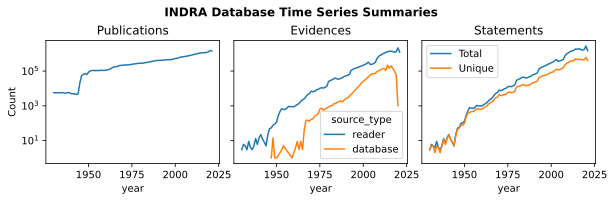

In [85]:
fig, ((lax, miax, rax)) = plt.subplots(1, 3, figsize=(8.5, 3), sharex=True, sharey=True)

sns.lineplot(
    data=year_df[year_df["year"].between(min_year, max_year)],
    x="year",
    y="publications",
    ax=lax,
)
lax.set_title("Publications")
lax.set_ylabel("Count")
# lax.set_yscale("log")

sns.lineplot(
    data=df3[df3["year"].between(min_year, max_year)],
    x="year",
    y="count",
    hue="source_type",
    estimator="sum",
    errorbar=None,
    ax=miax,
)
miax.set_title("Evidences")
miax.set_ylabel("")
# miax.set_yscale("log")


sns.lineplot(
    data=df4[df4["year"].between(min_year, max_year)],
    x="year",
    y="count",
    estimator="sum",
    errorbar=None,
    ax=rax,
    label="Total",
)
sns.lineplot(
    data=statement_first_appearance_df[
        statement_first_appearance_df["year"].between(min_year, max_year)
    ],
    x="year",
    y="count",
    ax=rax,
    label="Unique",
)

rax.set_title("Statements")
rax.set_ylabel("")
lax.set_yscale("log")

plt.suptitle("INDRA Database Time Series Summaries", fontweight="bold", y=0.92)
plt.tight_layout()
fig.savefig("/Users/cthoyt/Desktop/indra_db_time_summary.png", dpi=300)

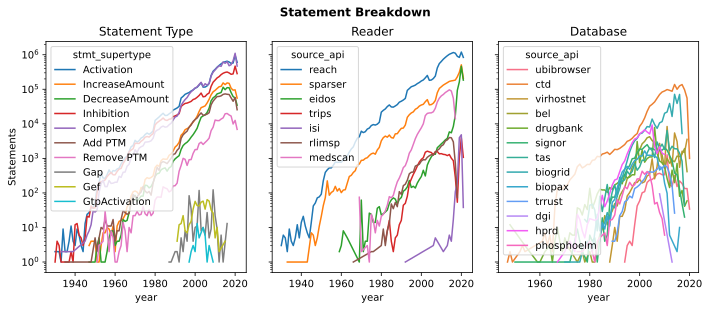

In [75]:
fig, (lax, miax, rax) = plt.subplots(1, 3, figsize=(10, 4.5), sharey=True)

sns.lineplot(
    data=df4[df4["year"].between(min_year, max_year)],
    x="year",
    y="count",
    hue="stmt_supertype",
    estimator="sum",
    errorbar=None,
    ax=lax,
)
lax.set_ylabel("Statements")
lax.set_yscale("log")
lax.set_title("Statement Type")


sns.lineplot(
    data=df3[
        df3["year"].between(min_year, max_year) & (df3["source_type"] == "reader")
    ],
    x="year",
    y="count",
    hue="source_api",
    ax=miax,
)
miax.set_ylabel("Evidences")
miax.set_yscale("log")
miax.set_title("Reader")

sns.lineplot(
    data=df3[
        df3["year"].between(min_year, max_year) & (df3["source_type"] == "database")
    ],
    x="year",
    y="count",
    hue="source_api",
    ax=rax,
)
rax.set_ylabel("Evidences")
rax.set_yscale("log")
rax.set_title("Database")

plt.suptitle("Statement Breakdown", fontweight="bold", y=0.95)
plt.tight_layout()
plt.show()

In [12]:
%%time

res = client.query_tx(
    """
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE e.stmt_hash = r.stmt_hash and pub.year < 1900
RETURN pub, collect(r.stmt_hash)
"""
)
len(res)

NameError: name 'old_statement_cypher' is not defined

# Old Statements

Get all statements with evidences that are from before a certain date. Many of the references point towards papers that only have digital scans.

In [13]:
old_statement_cutoff = 1920

In [14]:
%%time


old_statement_res = client.query_tx(
    f"""
MATCH p=()-[r:indra_rel]->()
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE e.stmt_hash = r.stmt_hash and pub.year < {old_statement_cutoff}
RETURN pub, collect(r.stmt_hash)
"""
)

CPU times: user 7.29 ms, sys: 2.48 ms, total: 9.77 ms
Wall time: 36.9 s


In [15]:
old_statement_res_processed = sorted(
    (
        pub["year"],
        pmid := pub["id"].removeprefix("pubmed:"),
        pub["pmcid"],
        pubmed_client.get_title(pmid),
        run_preassembly(get_stmts_for_stmt_hashes(stmt_hashes)),
    )
    for pub, stmt_hashes in tqdm(old_statement_res)
)

  0%|          | 0/47 [00:00<?, ?it/s]

INFO: [2023-01-06 08:50:30] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:50:30] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:50:30] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:50:30] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-06 08:50:30] indra_cogex.client.queries - got 1 evidences in 0.14 seconds
INFO: [2023-01-06 08:50:30] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-06 08:50:31] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-06 08:50:31] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations:   0%|                       | 0/1 [00:00<?, ?it/s]INFO: [2023-01-06 08:50:31] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/cthoyt/.indra/bio_ontology/1.28/bio_ontolo

INFO: [2023-01-06 08:51:04] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:51:05] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-06 08:51:05] indra_cogex.client.queries - got 1 evidences in 0.13 seconds
INFO: [2023-01-06 08:51:05] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-06 08:51:05] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-06 08:51:05] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1476.87it/s]
INFO: [2023-01-06 08:51:05] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-06 08:51:05] indra.preassembler - Total comparisons: 0
INFO: [2023-01-06 08:51:05] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-06 08:51:05] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-06 08:51:05] indra.tools.as

Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 2582.70it/s]
INFO: [2023-01-06 08:51:09] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-06 08:51:09] indra.preassembler - Total comparisons: 0
INFO: [2023-01-06 08:51:09] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-06 08:51:09] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-06 08:51:09] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-06 08:51:10] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:51:10] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:10] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:51:10] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-06 08:51:10] indra_cogex.client.queries - got 1 evidences in 0.13 seconds
INFO:

INFO: [2023-01-06 08:51:16] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:16] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:51:17] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-06 08:51:17] indra_cogex.client.queries - got 1 evidences in 0.15 seconds
INFO: [2023-01-06 08:51:17] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-06 08:51:17] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-06 08:51:17] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations: 100%|██████████████| 1/1 [00:00<00:00, 838.86it/s]
INFO: [2023-01-06 08:51:17] indra.preassembler - Found 0 refinements in 0.01s
INFO: [2023-01-06 08:51:17] indra.preassembler - Total comparisons: 0
INFO: [2023-01-06 08:51:17] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023

INFO: [2023-01-06 08:51:24] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 1473.24it/s]
INFO: [2023-01-06 08:51:24] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-06 08:51:24] indra.preassembler - Total comparisons: 0
INFO: [2023-01-06 08:51:24] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-06 08:51:24] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-06 08:51:24] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-06 08:51:24] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:51:24] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:24] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:51:25] indra_cogex.client.queries - looking up evidence for 1 statement

INFO: [2023-01-06 08:51:29] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:51:29] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:29] indra_cogex.client.queries - Getting statements for 5 hashes
INFO: [2023-01-06 08:51:29] indra_cogex.client.queries - looking up evidence for 5 statements
INFO: [2023-01-06 08:51:29] indra_cogex.client.queries - got 5 evidences in 0.13 seconds
INFO: [2023-01-06 08:51:29] indra.tools.assemble_corpus - Combining duplicates on 5 statements...
INFO: [2023-01-06 08:51:29] indra.tools.assemble_corpus - 5 unique statements
INFO: [2023-01-06 08:51:29] indra.tools.assemble_corpus - Combining related on 5 statements...

Finding refinement relations: 100%|█████████████| 5/5 [00:00<00:00, 3259.48it/s]
INFO: [2023-01-06 08:51:29] indra.preassembler - Found 0 refinements in 0.01s
INFO: [2023-01-06 08:51:29] indra.preassembler - Total comparisons: 0

INFO: [2023-01-06 08:51:34] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-06 08:51:34] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 2198.27it/s]
INFO: [2023-01-06 08:51:34] indra.preassembler - Found 0 refinements in 0.00s
INFO: [2023-01-06 08:51:34] indra.preassembler - Total comparisons: 0
INFO: [2023-01-06 08:51:34] indra.tools.assemble_corpus - Filtering 1 statements for top-level...
INFO: [2023-01-06 08:51:34] indra.tools.assemble_corpus - 1 statements after filter...
INFO: [2023-01-06 08:51:34] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-06 08:51:34] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:51:34] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:34] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01

INFO: [2023-01-06 08:51:54] indra.tools.assemble_corpus - 1 top-level statements
INFO: [2023-01-06 08:51:54] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 08:51:54] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection
INFO: [2023-01-06 08:51:54] indra_cogex.client.queries - Getting statements for 1 hashes
INFO: [2023-01-06 08:51:54] indra_cogex.client.queries - looking up evidence for 1 statements
INFO: [2023-01-06 08:51:55] indra_cogex.client.queries - got 1 evidences in 0.14 seconds
INFO: [2023-01-06 08:51:55] indra.tools.assemble_corpus - Combining duplicates on 1 statements...
INFO: [2023-01-06 08:51:55] indra.tools.assemble_corpus - 1 unique statements
INFO: [2023-01-06 08:51:55] indra.tools.assemble_corpus - Combining related on 1 statements...

Finding refinement relations: 100%|█████████████| 1/1 [00:00<00:00, 4760.84it/s]
INFO: [2023-01-06 08:51:55] indra.preassembler - Found 0 refinemen

In [16]:
old_statement_df = pd.DataFrame(
    [
        (year, pmid, pmc or "", title, len(stmts), EnglishAssembler(stmts).make_model())
        for year, pmid, pmc, title, stmts in old_statement_res_processed
    ],
    columns=["year", "pubmed", "pmc", "title", "n_statements", "statments"],
)

display(
    Markdown(
        dedent(
            f"""\
    The INDRA Database contains {len(old_statement_df.index)} papers annotated as being published before {old_statement_cutoff}\
    that together contain {old_statement_df.n_statements.sum()} INDRA statements. The oldest paper is from\
    {old_statement_res_processed[0][0]} entitled *{old_statement_res_processed[0][3].rstrip(".")}*\
    ([pubmed:{old_statement_res_processed[0][1]}](https://bioregistry.io/pubmed:{old_statement_res_processed[0][1]}))\
    and contains the following statements:
    
    {EnglishAssembler(old_statement_res_processed[0][4]).make_model()}
"""
        )
    )
)

old_statement_df.to_csv(
    "/Users/cthoyt/Desktop/old_indra_statements.tsv", sep="\t", index=False
)
old_statement_df.head(10)

The INDRA Database contains 47 papers annotated as being published before 1920    that together contain 63 INDRA statements. The oldest paper is from    1810 entitled *Observations on the Effects of Magnesia, in Preventing an Increased Formation of Uric Acid; with Some Remarks on the Composition of the Urine*    ([pubmed:30492701](https://bioregistry.io/pubmed:30492701))    and contains the following statements:

Magnesium oxide inhibits uric acid.


,year,pubmed,pmc,title,n_statements,statments
0,1810,30492701,PMC5694312,"Observations on the Effects of Magnesia, in Pr...",1,Magnesium oxide inhibits uric acid.
1,1830,30495358,PMC5671147,"Case of Intestinal Obstruction, Caused by Stri...",1,"Constriction, Pathologic activates casE."
2,1849,35374888,PMC8412535,Tetanus Produced by the Application of Nitrate...,2,Nitrate activates Tetanus. Silver(1+) activate...
3,1851,35375161,PMC8439798,On the Employment of Tartar Emetic to Relieve ...,1,Dipotassium bis[mu-tartrato(4-)]diantimonate(2...
4,1852,35375507,PMC8663383,On the Arrest of Typhus Fever by Quinine.,1,"Quinine inhibits Typhus, Epidemic Louse-Borne."
5,1855,35375820,PMC8676795,"A Respiratory Sound, Produced by a Tumor of th...",1,Neoplasms activates Respiratory Sounds.
6,1861,29647165,PMC5307054,On the Waxy or Amyloid Form of Bright's Disease.,1,ARID3A binds IAPP.
7,1864,29646175,PMC5311527,Further Observations on the Waxy or Amyloid Fo...,1,ARID3A binds IAPP.
8,1881,35826324,PMC8858189,Premature Labor Induced by Quinine.,1,"Quinine activates Obstetric Labor, Premature."
9,1884,17231514,PMC1288438,The Urea Elimination under the Use of Potassiu...,1,Urea inhibits potassium fluoride.


# Evidence Density

Summarize how many evidences are associated with each publication

In [17]:
%%time

evidence_density_result = client.query_tx(
    """
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE pub.year IS NOT NULL
RETURN pub.id, pub.year, count(e)
"""
)
len(evidence_density_result)

CPU times: user 1min 49s, sys: 9.91 s, total: 1min 59s
Wall time: 6min 45s


3467179

In [18]:
evidence_density_df = pd.DataFrame(
    sorted(
        (year, int(curie.removeprefix("pubmed:")), count)
        for curie, year, count in evidence_density_result
    ),
    columns=["year", "pubmed", "count"],
)
evidence_density_df

  0%|          | 0.00/3.47M [00:00<?, ?row/s]

,year,pubmed,count
0,1810,30492701,1
1,1830,30495358,1
2,1849,35374888,2
3,1851,35375161,1
4,1852,35375507,1
...,...,...,...
3467174,2022,35871433,6
3467175,2022,35871434,2
3467176,2022,35871482,1
3467177,2022,35871491,9


In [19]:
%%time

# histogram of number of statements per publication
statements_per_publication_cypher = """
MATCH p=()-[r:indra_rel]->()
MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
WHERE r.stmt_hash = e.stmt_hash
WITH pub.id as curie, count(r.stmt_hash) as statements
RETURN statements, count(statements)
ORDER BY statements
"""

statements_per_publication_df = pd.DataFrame(
    client.query_tx(statements_per_publication_cypher), columns=["statements", "count"]
)
statements_per_publication_df

CPU times: user 36.8 ms, sys: 8.32 ms, total: 45.1 ms
Wall time: 2min 19s


,statements,count
0,1,1029696
1,2,703413
2,3,301862
3,4,257068
4,5,146389
...,...,...
924,30994,1
925,33057,1
926,33433,1
927,47400,1


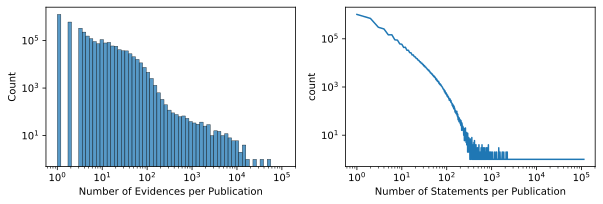

In [20]:
fig, (lax, rax) = plt.subplots(1, 2, figsize=(8.5, 3), sharex=True)

sns.histplot(
    data=evidence_density_df,
    x="count",
    log_scale=True,
    bins=60,
    ax=lax,
)
lax.set_yscale("log")
lax.set_xlabel("Number of Evidences per Publication")

sns.lineplot(
    data=statements_per_publication_df,
    x="statements",
    y="count",
    ax=rax,
)
rax.set_yscale("log")
rax.set_xscale("log")
rax.set_xlabel("Number of Statements per Publication")

plt.tight_layout()
plt.show()

In [21]:
%%time

evidence_per_statement_cypher = """
MATCH p=()-[r:indra_rel]->()
MATCH (e:Evidence)
WHERE r.stmt_hash = e.stmt_hash
WITH r.stmt_hash as stmt_hash, count(e.id) as evidences
RETURN evidences, count(evidences) as count
ORDER BY evidences
"""

evidence_per_statement_df = pd.DataFrame(
    client.query_tx(evidence_per_statement_cypher), columns=["evidences", "count"]
)

CPU times: user 54.3 ms, sys: 8.02 ms, total: 62.3 ms
Wall time: 1min 51s


# TODO

- number statements per evidence
- Distribution of number of evidences per publication (stratify over time)
- Time between first and second evidence for each statement

# Statements for Given Entity over time

Using TP53 as a first example

In [37]:
def get_entity_summary_cypher(curie: str) -> str:
    return dedent(
        f"""\
        MATCH p=(h:BioEntity {{id: "{curie}"}})-[r:indra_rel]-(t:BioEntity)
        MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
        WHERE e.stmt_hash = r.stmt_hash and pub.year IS NOT NULL
        RETURN pub.year, count(pub.year)
        ORDER BY pub.year ASC
    """
    ).rstrip()


def get_entity_first_cypher(curie: str) -> str:
    return dedent(
        f"""\
        MATCH p=(h:BioEntity {{id: "{curie}"}})-[r:indra_rel]-(t:BioEntity)
        MATCH (e:Evidence)-[:has_citation]->(pub:Publication)
        WHERE e.stmt_hash = r.stmt_hash and pub.year IS NOT NULL
        WITH r.stmt_hash as stmt_hash, min(pub.year) as year
        RETURN year, count(year) as count
        ORDER BY year ASC
        """
    ).rstrip()


@lru_cache(100)
def get_entity_summary_df(curie, *, first: bool):
    f = get_entity_first_cypher if first else get_entity_summary_cypher
    return pd.DataFrame(
        client.query_tx(f(curie)),
        columns=["year", "count"],
    )

In [38]:
def get_entity_cumsum_df(curie, *, first: bool):
    df = get_entity_summary_df(curie=curie, first=first).sort_values("year")
    df["count"] = df.cumsum()["count"]
    return df


def plot_entity_summary(
    curie, *, ax=None, first: bool = False, cumsum: bool = False, **kwargs
):
    f = get_entity_cumsum_df if cumsum else get_entity_summary_df
    ax2 = sns.lineplot(
        data=f(curie, first=first),
        x="year",
        y="count",
        ax=ax,
        **kwargs,
    )
    if ax is None:
        ax2.set_yscale("log")
    return ax2

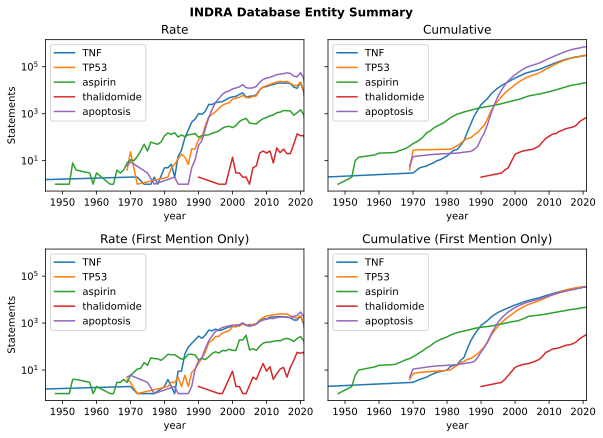

In [78]:
fig, ((lax, rax), (lax2, rax2)) = plt.subplots(2, 2, figsize=(8.5, 6.3), sharey=True)

for ax, cumsum, first, title in [
    (lax, False, False, "Rate"),
    (rax, True, False, "Cumulative"),
    (lax2, False, True, "Rate (First Mention Only)"),
    (rax2, True, True, "Cumulative (First Mention Only)"),
]:
    for curie, label in [
        ("hgnc:11892", "TNF"),
        ("hgnc:11998", "TP53"),
        ("chebi:15365", "aspirin"),
        ("chebi:9513", "thalidomide"),
        ("go:0006915", "apoptosis"),
        # ("doid:0080600", "COVID-19"),  # doesn't return anything
    ]:
        plot_entity_summary(curie, label=label, ax=ax, cumsum=cumsum, first=first)

    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylabel("Statements")
    ax.set_xlim([1945, max_year])

fig.suptitle("INDRA Database Entity Summary", fontweight="bold", y=0.96)
fig.tight_layout()
fig.savefig("/Users/cthoyt/Desktop/entities_over_time.png", dpi=300)
plt.show()